# <center>Pixel-wise neurovascular CURBD Pipeline <center>

#### Basé sur les calculs Perich, M. G., Arlt, C., Soares, S., Young, M. E., Mosher, C. P., Minxha, J., Carter, E., Rutishauser, U., Rudebeck, P. H., Harvey, C. D., & Rajan, K. (2020). Inferring brain-wide interactions using data-constrained recurrent neural network models. Cold Spring Harbor Laboratory. https://doi.org/10.1101/2020.12.18.423348

### Par Pierre-Luc Larouche et Alexandre Cléroux Cuillerier

### Importation des librairies

In [2]:
# Import des librairie importantes
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from numba import njit, prange
from scipy.ndimage import gaussian_filter

In [3]:
# Quelques généralités importante dans le layout des figures
plt.rcParams.update({'font.size': 16})
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 5
cmap = "coolwarm"

### Classe génératrice de données synthétiques

In [4]:
class GeneratorModel3R:
    def __init__(self, N: int, g_AB: tuple, w_rgn: float, p_rgn: float):
        self.N = N # Nombre de neurones
        self.tau = 0.1 # Pas de temps
        self.w_in = 1.0 #
        self.p_rgn = p_rgn
        
        self.J = np.empty((3*self.N, 3*self.N))
        for i in range(3):
            for j in range(3):
                if i == j:
                    dist = g_AB[i] * np.random.normal(loc=0.0, scale=np.sqrt(g_AB[i]**2/(self.N)), size=(self.N, self.N))
                else:
                    dist =  w_rgn * np.random.choice([0.0, 1.0], size=(self.N, self.N), p=[1-self.p_rgn, self.p_rgn])
                self.J[i*self.N:(i+1)*self.N, j*self.N:(j+1)*N] = dist
        C_SA = np.zeros((self.N, 1))
        C_SB = np.random.choice([0.0, -1.0], size=(self.N, 1), p=[1-0.5, 0.5])
        C_SC = np.random.choice([0.0, 1.0], size=(self.N, 1), p=[1-0.5, 0.5])
        self.C_S = self.w_in * np.concatenate((C_SA, C_SB, C_SC))

        self.r = np.random.uniform(low=-1.0, high=1.0, size=(3*self.N, 1))
    
    def drdt(self, S: np.array):
        dr = 1/self.tau * (-self.r + self.J @ np.tanh(self.r) + self.C_S * S)
        return dr
    
    def signal(self, t: float):
        def SQ(t: float):
            indices = np.arange(self.N).reshape(self.N, 1)
            num = (indices - int(self.N/5) - self.N*t/10)**2
            den = 2 * (int(self.N/5))**2
            return np.exp(-num/den)
        if t < 2.0:
            S_B = SQ(2.0)
            S_C = SQ(2.0)
        elif t < 6.0:
            S_B = SQ(t)
            S_C = SQ(2.0)
        elif t < 8.0:
            S_B = SQ(6.0)
            S_C = SQ(2.0)
        else:
            S_B = SQ(6.0)
            S_C = SQ(5.0)

        S = np.concatenate((np.full((self.N, 1), 0.0), S_B,  S_C))
        return S
    
    def integrate(self, time: np.array):
        h = time[1]-time[0]
        rA = np.empty((self.N, len(time)))
        rB = np.empty((self.N, len(time)))
        rC = np.empty((self.N, len(time)))
        for i, t in enumerate(time):
            S = self.signal(t)
            dr = self.drdt(S)
            self.r = self.r + h * dr
            rA[:, i] = self.r[:self.N, 0]
            rB[:, i] = self.r[self.N:2*self.N, 0]
            rC[:, i] = self.r[2*self.N:, 0]
        return rA, rB, rC

### Les fonctions accélérés par décorateur

In [5]:
@njit
def dxdt(tau, x_vector, g, J, h):
    return 1/tau * (-x_vector + g * J @ np.tanh(x_vector) + h)

In [6]:
@njit
def dhdt(N,h):
    eta = np.random.normal(loc=0.0, scale=1.0, size=(N, 1))
    return 1/0.1 * (-h + eta)

In [7]:
@njit
def update_J(x, P, J, f):
    
    cte = (1/(1 + np.tanh(x).T @ P @ np.tanh(x)))[0][0]
    error = np.tanh(x) - f
    
    P = P - P @ np.tanh(x) @ np.tanh(x).T @ P * cte
    J = J - cte * error @ (P @ np.tanh(x)).T
    
    return P, J

In [8]:
@njit
def integrate(time, N, tau, x_vector, g, J, h):
    
    dt = time[1]-time[0]
    x = np.empty((N, len(time)))
    
    for i, t in enumerate(time):
        
        h = h + dt * dhdt(N,h)
        x_vector = x_vector + dt * dxdt(tau, x_vector, g, J, h)
        x[:, i] = x_vector[:, 0]
        
    return x

In [9]:
@njit
def learn(N, x_vector, time, signal, tau, g, J, h, P):
    
    # Initialisation de différentes matrices vides et constantes
    dt = time[1]-time[0]
    J_mean = np.empty(len(time))
    x_list = np.empty((N, len(time)))
    f = np.empty((N, 1))
    
    
    for i in range(len(time)):
        
        f[:, 0] = signal[:, i]
        h = h + dt * dhdt(N,h)
        x_vector = x_vector + dt * dxdt(tau, x_vector, g, J, h)
        
        x_list[:, i] = x_vector[:, 0]

        if not (i+1) % 2:
            P, J = update_J(x_vector, P, J, f)
            
        a = np.abs(J)
        J_mean[i] = a.mean()

    return x_vector, x_list, J, J_mean, P

### 3 regions model

In [18]:
model = GeneratorModel3R(N=200, g_AB=[1.8, 1.5, 1.5], w_rgn=0.01, p_rgn=0.01)
time = np.arange(0.0, 12.0, 0.01)

#rA, rB, rC = model.integrate(time=time)
#np.save("3R_rA_300.npy", rA)
#np.save("3R_rB_300.npy", rB)
#np.save("3R_rC_300.npy", rC)
#np.save("3R_modelJ_300.npy", model.J)

rA = np.load("3R_rA_300.npy")
rB = np.load("3R_rB_300.npy")
rC = np.load("3R_rC_300.npy")
model.J = np.load("3R_modelJ_300.npy")

FileNotFoundError: [Errno 2] No such file or directory: '3R_rA_300.npy'

NameError: name 'time' is not defined

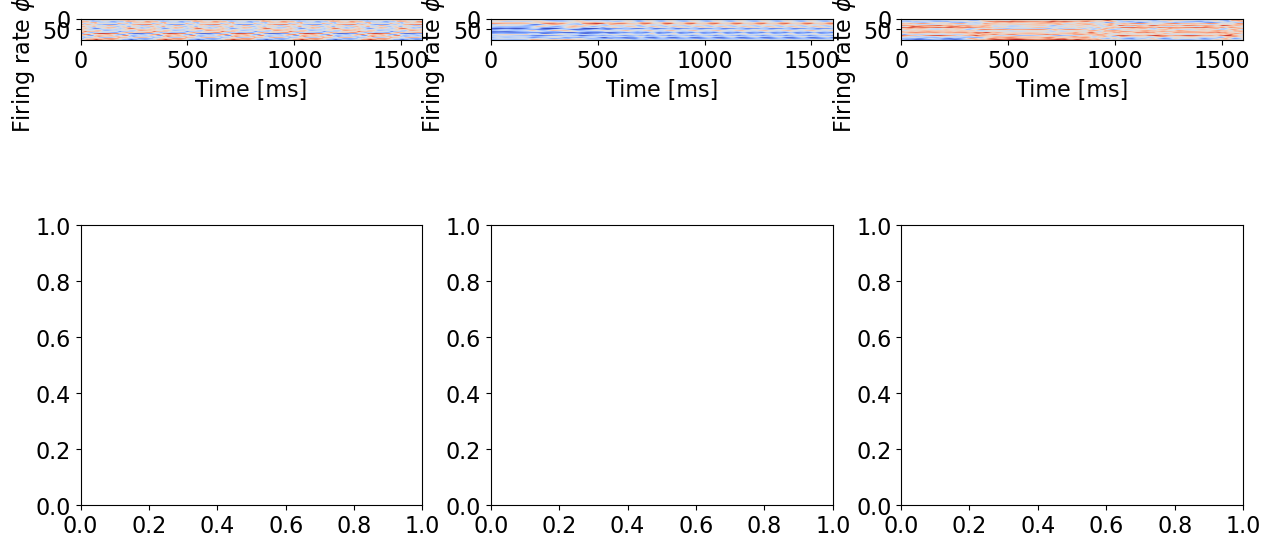

In [105]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 8))

ax1.imshow(np.tanh(rA), cmap=cmap, vmin=-1.0, vmax=1.0)
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Firing rate $\phi_A(t)$ [-]")

ax2.imshow(np.tanh(rB), cmap=cmap, vmin=-1.0, vmax=1.0)
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Firing rate $\phi_B(t)$ [-]") 

ax3.imshow(np.tanh(rC), cmap=cmap, vmin=-1.0, vmax=1.0)
ax3.set_xlabel("Time [ms]")
ax3.set_ylabel("Firing rate $\phi_C(t)$ [-]") 

ax4.plot(time, np.mean(np.tanh(rA), axis=0), label="Truth")
ax4.legend()
ax4.set_xlabel("Time [ms]")
ax4.set_ylabel("Firing rate $\phi_A(t)$ [-]")

ax5.plot(time, np.mean(np.tanh(rB), axis=0), label="Truth")
ax5.legend()
ax5.set_xlabel("Time [ms]")
ax5.set_ylabel("Firing rate $\phi_B(t)$ [-]")

ax6.plot(time, np.mean(np.tanh(rC), axis=0), label="Truth")
ax6.legend()
ax6.set_xlabel("Time [ms]")
ax6.set_ylabel("Firing rate $\phi_C(t)$ [-]")

plt.tight_layout()
plt.show()


## Numba

In [74]:
# On défini un network hors classe

# D'abord quelques constantes
N = 300 # Nombre de neurones
tau = 0.1 # Pas de temps
alpha = 1.0 # Valeur du bruit initial sur la diagonale de P
g = 1.5 # Constante de force des connections récurentes
J_list = []


# Ensuite quelques vecteurs et matrices
J = np.random.normal(loc=0.0, scale=g/np.sqrt(N), size=(N, N)) 
P = 1/alpha * np.identity(n=N)
x_vector = np.random.uniform(low=-1.0, high=1.0, size=(N, 1))
h = np.random.uniform(low=-1.0, high=1.0, size=(N, 1))

# On définie le teacher
teacher = np.concatenate((np.tanh(rA), np.tanh(rB), np.tanh(rC)), axis=0)
blurred_teacher = gaussian_blurer(teacher)

In [75]:
# C'est parti pour le learning
for i in tqdm(range(10)):
    x_vector, x_list, J, J_mean, P = learn(N, x_vector, time, teacher, tau, g, J, h, P)
    J_list.append(J_mean)
    
# On save sous forme de .npy
np.save("3R_training_numba.npy", J_list)
np.save("3R_netJ_numba.npy", J)
np.save("3R_x_numba.npy", x_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


In [10]:
# NUMBA
J_list = np.load("J_list_100.npy")
J = np.load("J_100.npy")
x_list = np.load("x_list_100.npy")

NameError: name 'teacher' is not defined

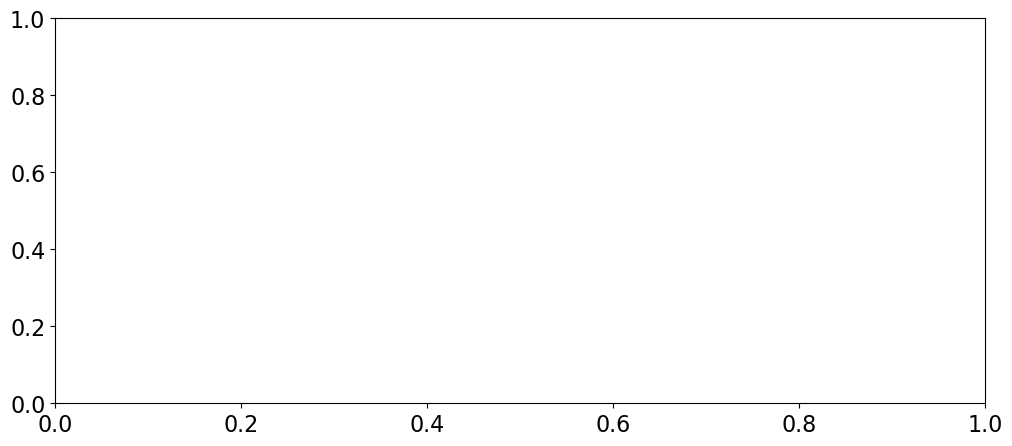

In [11]:
# NUMBA
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
ax1.plot(teacher[0], color="black", label='Activité neuronale')
ax1.plot(blurred_teacher[0], color="blue", label='Activité neuronale blurred')
ax1.plot(np.tanh(x_list[0]), color="red", label='Activité des neurones du RNN')
for idx, i in enumerate(range(0,10)) :
    ax1.plot(blurred_teacher[i+1]+(idx+1)*3, color="blue")
    ax1.plot(teacher[i+1]+(idx+1)*3, color="black")
    ax1.plot(np.tanh(x_list[i+1])+(idx+1)*3, color="red")
ax1.set_xlabel("Time [cs]")
ax1.set_ylabel("Sortie des neurones [-]")
ax1.tick_params(left=False)
ax1.set(yticklabels=[])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

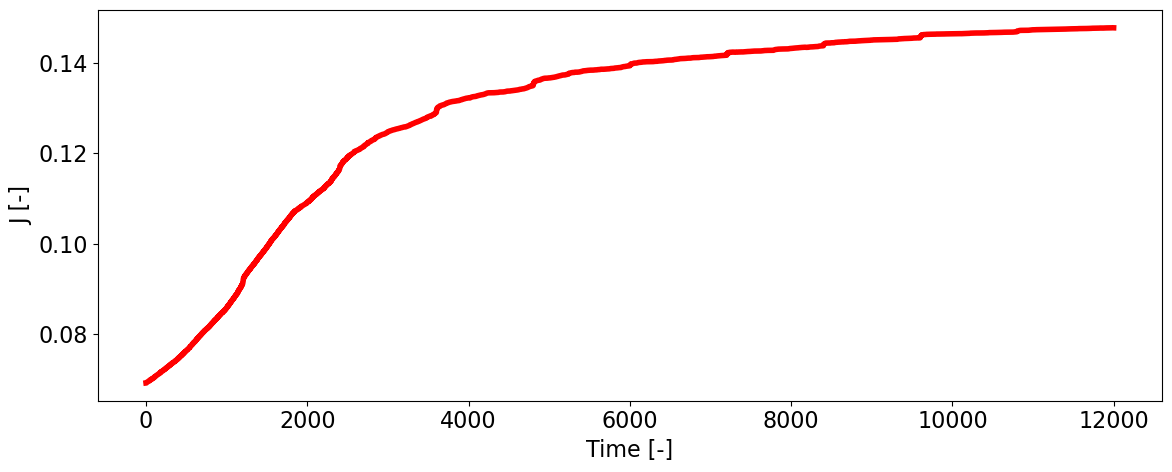

In [12]:
# NUMBA
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
J_abslist = []
for i in J_list :
    for j in i :
        J_abslist.append(j) 
ax1.plot(J_abslist, color="red")
ax1.set_xlabel("Time [-]")
ax1.set_ylabel("J [-]")

plt.tight_layout()
plt.show()

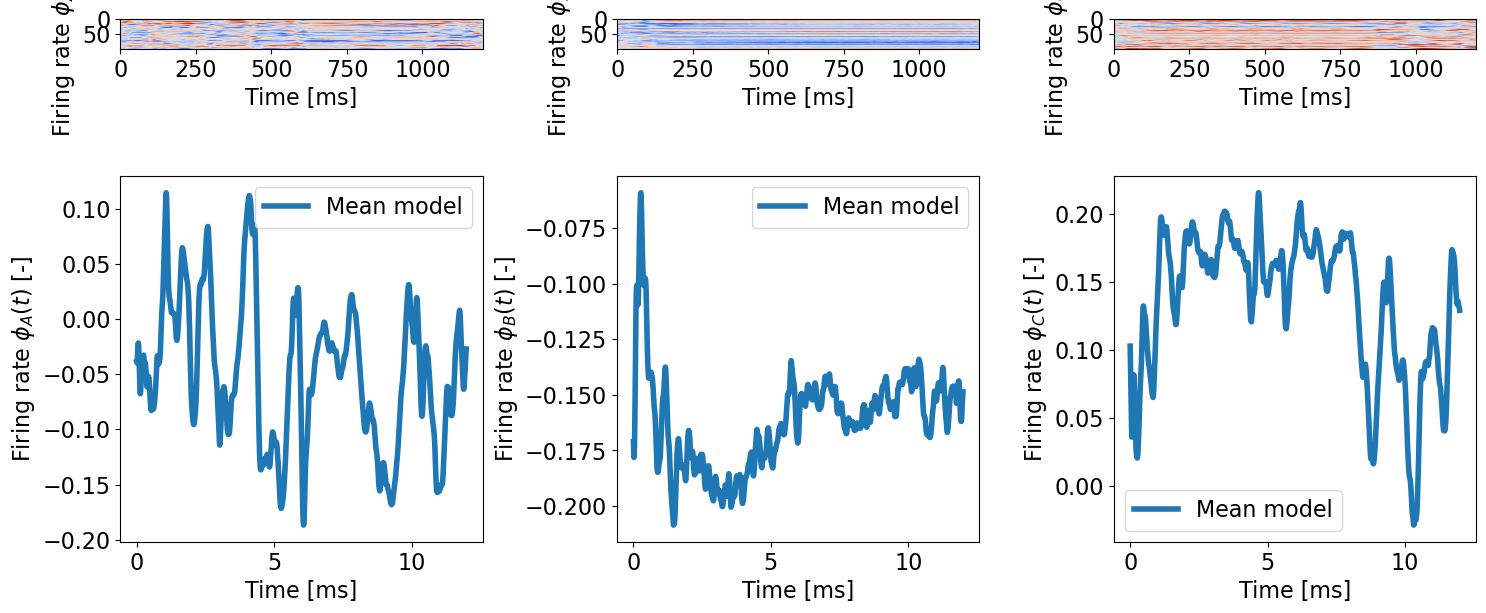

In [15]:
N = 300
time = np.arange(0.0, 12.0, 0.01)
modelA, modelB, modelC = x_list[:100, :], x_list[100:200, :], x_list[200:300, :]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 8))

ax1.imshow(np.tanh(modelA), cmap=cmap, vmin=-1.0, vmax=1.0)
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Firing rate $\phi_A(t)$ [-]")

ax2.imshow(np.tanh(modelB), cmap=cmap, vmin=-1.0, vmax=1.0)
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Firing rate $\phi_B(t)$ [-]") 

ax3.imshow(np.tanh(modelC), cmap=cmap, vmin=-1.0, vmax=1.0)
ax3.set_xlabel("Time [ms]")
ax3.set_ylabel("Firing rate $\phi_C(t)$ [-]") 

#ax4.plot(time, np.mean(np.tanh(rA), axis=0), label="Mean data")
ax4.plot(time, np.mean(np.tanh(modelA), axis=0), label="Mean model")
ax4.legend()
ax4.set_xlabel("Time [ms]")
ax4.set_ylabel("Firing rate $\phi_A(t)$ [-]")

#ax5.plot(time, np.mean(np.tanh(rB), axis=0), label="Mean data")
ax5.plot(time, np.mean(np.tanh(modelB), axis=0), label="Mean model")
ax5.legend()
ax5.set_xlabel("Time [ms]")
ax5.set_ylabel("Firing rate $\phi_B(t)$ [-]")

#ax6.plot(time, np.mean(np.tanh(rC), axis=0), label="Mean data")
ax6.plot(time, np.mean(np.tanh(modelC), axis=0), label="Mean model")
ax6.legend()
ax6.set_xlabel("Time [ms]")
ax6.set_ylabel("Firing rate $\phi_C(t)$ [-]")

plt.tight_layout()
plt.show()

In [16]:
@njit
def compute_currents(J, region_size: int, no_regions: int, activity: np.array):    
    currents = list()
    for i in range(no_regions):
        for j in range(no_regions):
            neurons_subset = activity[j*region_size:(j+1)*region_size, :]
            J_subset = J[i*region_size:(i+1)*region_size, j*region_size:(j+1)*region_size]
            c_neurons_subset = np.ascontiguousarray(neurons_subset)
            c_J_subset = np.ascontiguousarray(J_subset)
            currents.append(c_J_subset @ c_neurons_subset)
    
    return currents

NameError: name 'currents_truth' is not defined

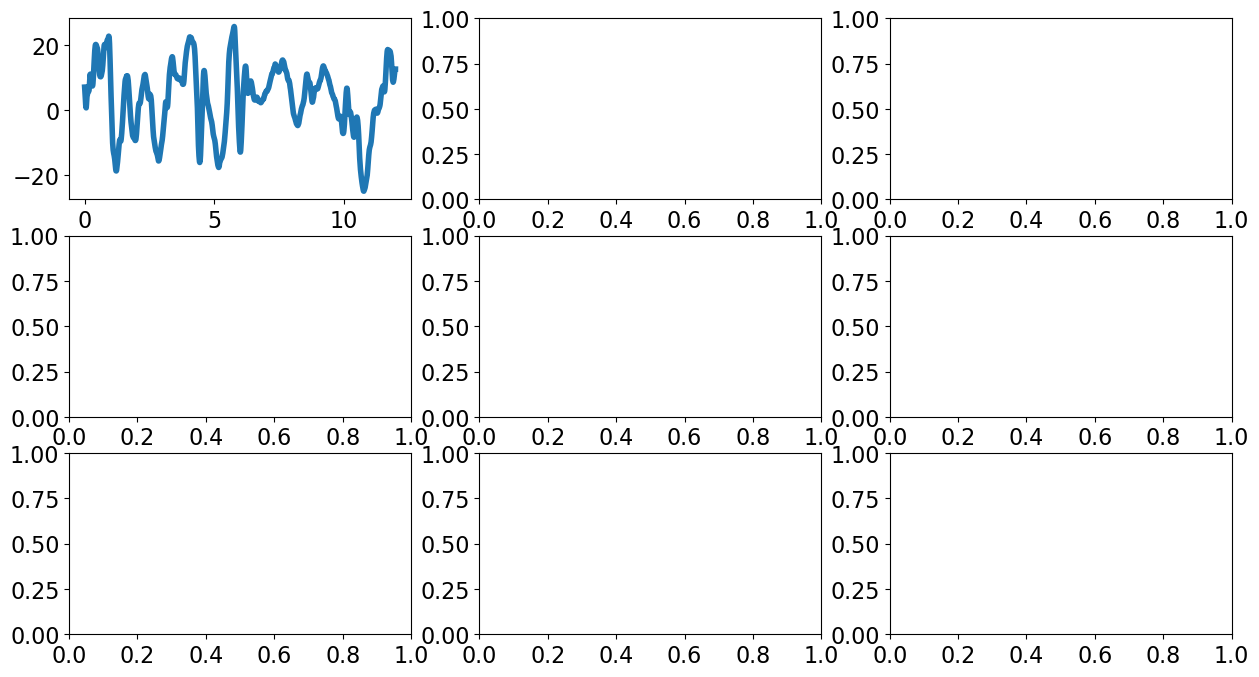

In [17]:
currents = compute_currents(J, region_size=100, no_regions=3, activity=np.tanh(x_list))
currents_truth = compute_currents(model.J, region_size=100, no_regions=3, activity=blurred_teacher)

fig, ax = plt.subplots(3, 3, figsize=(15, 8))

ax[0][0].plot(time, np.sum(currents[0], axis=0), label="RNN")
ax[0][0].plot(time, np.sum(currents_truth[0], axis=0), label="Truth0")
ax[0][0].legend()
ax[0][0].set_xlabel("Time [ms]")
ax[0][0].set_ylabel("Currents A to A")

ax[0][1].plot(time, np.sum(currents[1], axis=0), label="RNN")
ax[0][1].plot(time, np.sum(currents_truth[1], axis=0), label="Truth0")
ax[0][1].legend()
ax[0][1].set_xlabel("Time [ms]")
ax[0][1].set_ylabel("Currents B to A")

ax[0][2].plot(time, np.sum(currents[2], axis=0), label="RNN")
ax[0][2].plot(time, np.sum(currents_truth[2], axis=0), label="Truth0")
ax[0][2].legend()
ax[0][2].set_xlabel("Time [ms]")
ax[0][2].set_ylabel("Currents C to A")

ax[1][0].plot(time, np.sum(currents[3], axis=0), label="RNN")
ax[1][0].plot(time, np.sum(currents_truth[3], axis=0), label="Truth")
ax[1][0].legend()
ax[1][0].set_xlabel("Time [ms]")
ax[1][0].set_ylabel("Currents A to B")

ax[1][1].plot(time, np.sum(currents[4], axis=0), label="RNN")
ax[1][1].plot(time, np.sum(currents_truth[4], axis=0), label="Truth")
ax[1][1].legend()
ax[1][1].set_xlabel("Time [ms]")
ax[1][1].set_ylabel("Currents B to B")

ax[1][2].plot(time, np.sum(currents[5], axis=0), label="RNN")
ax[1][2].plot(time, np.sum(currents_truth[5], axis=0), label="Truth")
ax[1][2].legend()
ax[1][2].set_xlabel("Time [ms]")
ax[1][2].set_ylabel("Currents C to B")

ax[2][0].plot(time, np.sum(currents[6], axis=0), label="RNN")
ax[2][0].plot(time, np.sum(currents_truth[6], axis=0), label="Truth")
ax[2][0].legend()
ax[2][0].set_xlabel("Time [ms]")
ax[2][0].set_ylabel("Currents A to C")

ax[2][1].plot(time, np.sum(currents[7], axis=0), label="RNN")
ax[2][1].plot(time, np.sum(currents_truth[7], axis=0), label="Truth")
ax[2][1].legend()
ax[2][1].set_xlabel("Time [ms]")
ax[2][1].set_ylabel("Currents B to C")

ax[2][2].plot(time, np.sum(currents[8], axis=0), label="RNN")
ax[2][2].plot(time, np.sum(currents_truth[8], axis=0), label="Truth")
ax[2][2].legend()
ax[2][2].set_xlabel("Time [ms]")
ax[2][2].set_ylabel("Currents C to C")

plt.tight_layout()
plt.show()

In [82]:
pca_RNN = [None] * len(currents)
for i, curr in enumerate(currents):
    pca = PCA(n_components=2)
    components = pca.fit_transform(curr.T).T
    norm_component = components[0] / max(abs(components[0]))
    pca_RNN[i] = norm_component
    
pca_truth = [None] * len(currents_truth)
for i, curr in enumerate(currents_truth):
    pca = PCA(n_components=2)
    components = pca.fit_transform(curr.T).T
    norm_component = components[0] / max(abs(components[0]))
    pca_truth[i] = norm_component

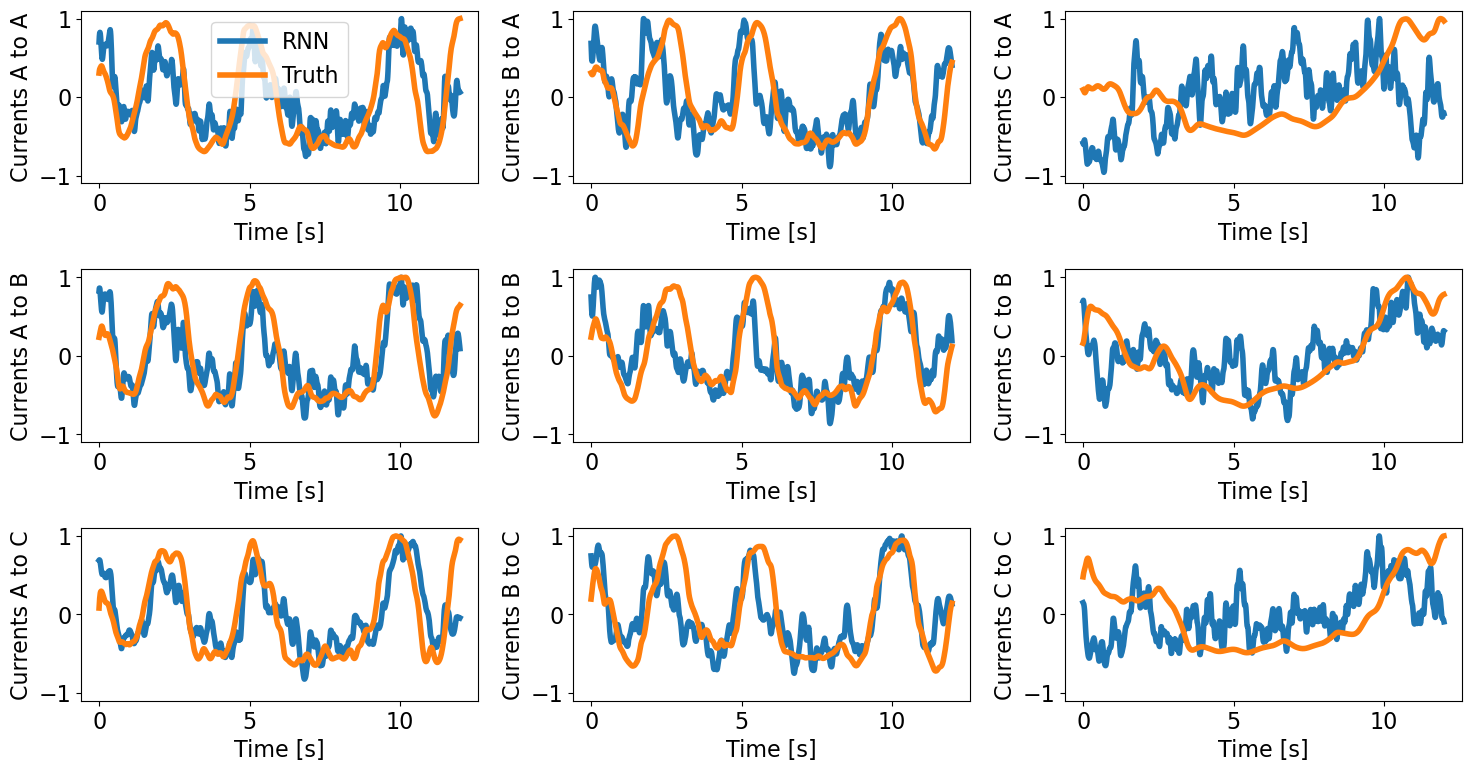

In [120]:
fig, ax = plt.subplots(3, 3, figsize=(15, 8))

ax[0][0].plot(time, pca_RNN[0], label="RNN")
ax[0][0].plot(time, pca_truth[0], label="Truth")
ax[0][0].legend()
ax[0][0].set_ylim([-1.1, 1.1])
ax[0][0].set_xlabel("Time [s]")
ax[0][0].set_ylabel("Currents A to A")

ax[0][1].plot(time, pca_RNN[1], label="RNN")
ax[0][1].plot(time, pca_truth[1], label="Truth")
# ax[0][1].legend()
ax[0][1].set_ylim([-1.1, 1.1])
ax[0][1].set_xlabel("Time [s]")
ax[0][1].set_ylabel("Currents B to A")

ax[0][2].plot(time, pca_RNN[2], label="RNN")
ax[0][2].plot(time, pca_truth[2], label="Truth")
# ax[0][2].legend()
ax[0][2].set_ylim([-1.1, 1.1])
ax[0][2].set_xlabel("Time [s]")
ax[0][2].set_ylabel("Currents C to A")

ax[1][0].plot(time, pca_RNN[3], label="RNN")
ax[1][0].plot(time, pca_truth[3], label="Truth")
# ax[1][0].legend()
ax[1][0].set_ylim([-1.1, 1.1])
ax[1][0].set_xlabel("Time [s]")
ax[1][0].set_ylabel("Currents A to B")

ax[1][1].plot(time, pca_RNN[4], label="RNN")
ax[1][1].plot(time, pca_truth[4], label="Truth")
# ax[1][1].legend()
ax[1][1].set_ylim([-1.1, 1.1])
ax[1][1].set_xlabel("Time [s]")
ax[1][1].set_ylabel("Currents B to B")

ax[1][2].plot(time, pca_RNN[5], label="RNN")
ax[1][2].plot(time, pca_truth[5], label="Truth")
# ax[1][2].legend()
ax[1][2].set_ylim([-1.1, 1.1])
ax[1][2].set_xlabel("Time [s]")
ax[1][2].set_ylabel("Currents C to B")

ax[2][0].plot(time, pca_RNN[6], label="RNN")
ax[2][0].plot(time, pca_truth[6], label="Truth")
# ax[2][0].legend()
ax[2][0].set_ylim([-1.1, 1.1])
ax[2][0].set_xlabel("Time [s]")
ax[2][0].set_ylabel("Currents A to C")

ax[2][1].plot(time, pca_RNN[7], label="RNN")
ax[2][1].plot(time, pca_truth[7], label="Truth")
# ax[2][1].legend()
ax[2][1].set_ylim([-1.1, 1.1])
ax[2][1].set_xlabel("Time [s]")
ax[2][1].set_ylabel("Currents B to C")

ax[2][2].plot(time, pca_RNN[8], label="RNN")
ax[2][2].plot(time, pca_truth[8], label="Truth")
# ax[2][2].legend()
ax[2][2].set_ylim([-1.1, 1.1])
ax[2][2].set_xlabel("Time [s]")
ax[2][2].set_ylabel("Currents C to C")

plt.tight_layout()
plt.show()

## Variabilité des courants tout court

In [69]:
model = GeneratorModel3R(N=100, g_AB=[1.8, 1.5, 1.5], w_rgn=0.01, p_rgn=0.01)
time = np.arange(0.0, 12.0, 0.01)
rA, rB, rC = model.integrate(time=time)
teacher = np.concatenate((np.tanh(rA), np.tanh(rB), np.tanh(rC)), axis=0)

In [70]:
# D'abord quelques constantes
N = 300 # Nombre de neurones
tau = 0.1 # Pas de temps
alpha = 1.0 # Valeur du bruit initial sur la diagonale de P
g = 1.5 # Constante de force des connections récurentes

In [71]:
j_list_variation = []
x_list_variation = []

for i in range(20) :
    J = np.random.normal(loc=0.0, scale=g/np.sqrt(N), size=(N, N)) 
    P = 1/alpha * np.identity(n=N)
    x_vector = np.random.uniform(low=-1.0, high=1.0, size=(N, 1))
    h = np.random.uniform(low=-1.0, high=1.0, size=(N, 1))
    
    for i in tqdm(range(15)):
        x_vector, x_list, J, J_mean, P = learn(N, x_vector, time, teacher, tau, g, J, h, P)
    j_list_variation.append(J)
    x_list_variation.append(x_list)

np.save("j_list_variation_600.npy", j_list_variation)
np.save("x_list_variation_600.npy", x_list_variation)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:26<00:00,  1.75s/it]


In [72]:
J_truth = model.J
x_list_truth = teacher

In [73]:
currents_list = []

currents_truth = compute_currents(J_truth, region_size=100, no_regions=3, activity=x_list_truth)
for idx, i in enumerate(x_list_variation): 
    currents_list.append(compute_currents(j_list_variation[idx], region_size=100, no_regions=3, activity=np.tanh(i)))

In [74]:
PCA_list = []
for currents in currents_list:
    pca_RNN = [None] * len(currents)
    for i, curr in enumerate(currents):
        pca = PCA(n_components=2)
        components = pca.fit_transform(curr.T).T
        norm_component = components[0] / max(abs(components[0]))
        pca_RNN[i] = norm_component
    PCA_list.append(pca_RNN)
    
pca_truth = [None] * len(currents_truth)
for i, curr in enumerate(currents_truth):
    pca = PCA(n_components=2)
    components = pca.fit_transform(curr.T).T
    norm_component = components[0] / max(abs(components[0]))
    pca_truth[i] = norm_component

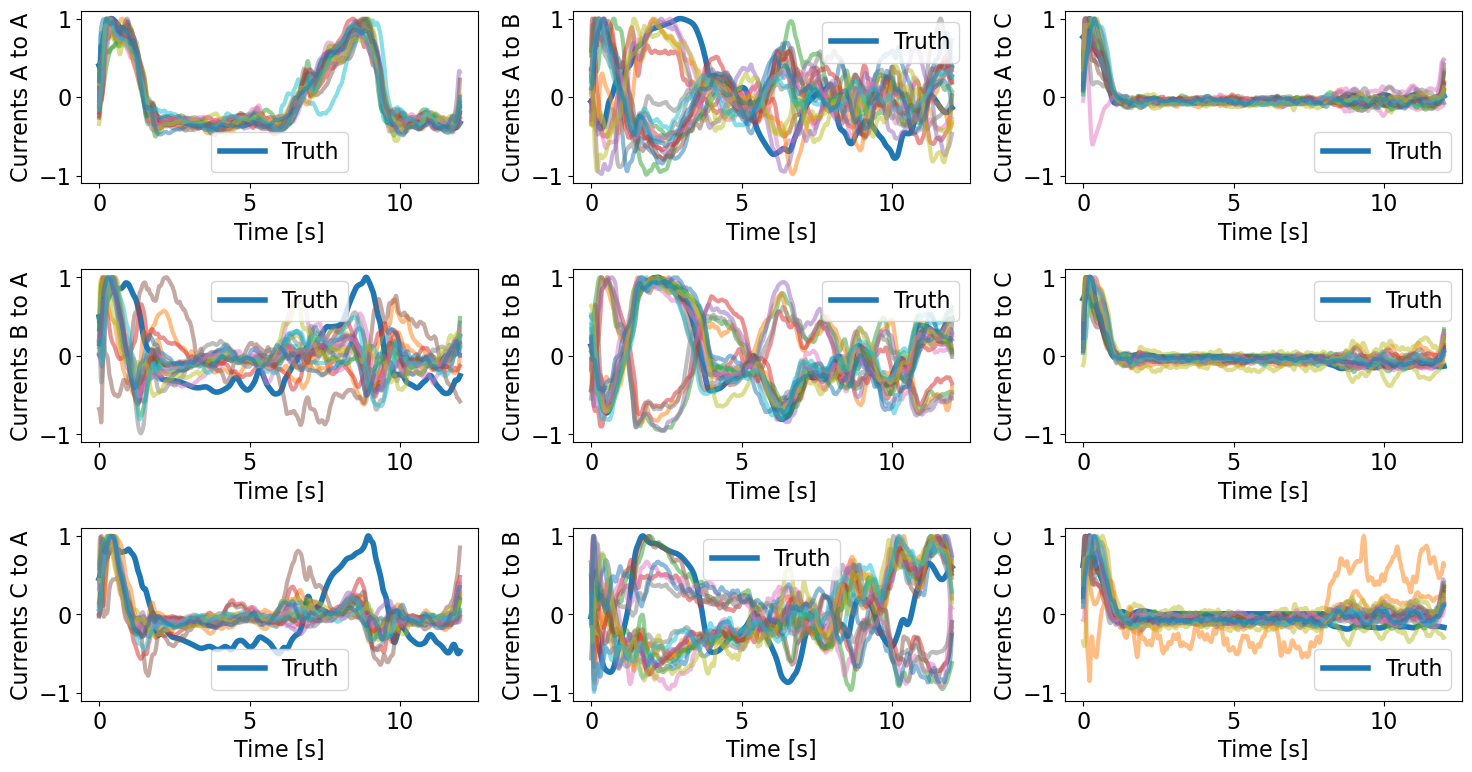

In [77]:
fig, ax = plt.subplots(3, 3, figsize=(15, 8))

letters = ['A', 'B', 'C']
a = 0
for i in range(3):
    
    for j in range(3):
        ax[i][j].plot(time, pca_truth[a], label="Truth")
        
        for k in range(20):
            ax[i][j].plot(time, PCA_list[k][a], linewidth=3, alpha=0.5)
            
        ax[i][j].legend()
        ax[i][j].set_ylim([-1.1, 1.1])
        ax[i][j].set_xlabel("Time [s]")
        ax[i][j].set_ylabel(f"Currents {letters[i]} to {letters[j]}")
        a += 1
        

plt.tight_layout()
plt.show()

## Variabilité des courants en fonction du ratio neurones/timesteps (VcurNTR)

In [15]:
model = GeneratorModel3R(N=100, g_AB=[1.8, 1.5, 1.5], w_rgn=0.01, p_rgn=0.01)

# Création d'une liste de pas de temps
time_list = []
for i in [1.0,2.0,4.0,6.0,8.0,10.0,12.0,16.0, 20.0, 24.0]:
    time_list.append(np.arange(0.0, i, 0.01))
    
# On génère une activité de neurones
rA, rB, rC = model.integrate(time=time_list[-1])
np.save("3R_rA_300_VcurNTR_24.npy", rA)
np.save("3R_rB_300_VcurNTR_24.npy", rB)
np.save("3R_rC_300_VcurNTR_24.npy", rC)
np.save("3R_modelJ_300_VcurNTR_24.npy", model.J)

In [27]:
# Définition des teacher
teacher_list = []
J_teachers_lists = []

rA = np.load("3R_rA_300_VcurNTR_24.npy")
rB = np.load("3R_rB_300_VcurNTR_24.npy")
rC = np.load("3R_rC_300_VcurNTR_24.npy")
model.J = np.load("3R_modelJ_300_VcurNTR_24.npy")
teacher = np.concatenate((np.tanh(rA), np.tanh(rB), np.tanh(rC)), axis=0)

for i in [1,2,4,6,8,10,12,16, 20, 24]:
    teacher_list.append(teacher[:,:i*100])

In [28]:
# D'abord quelques constantes
N = 300 # Nombre de neurones
tau = 0.1 # Pas de temps
alpha = 1.0 # Valeur du bruit initial sur la diagonale de P
g = 1.5 # Constante de force des connections récurentes

In [42]:
j_list_teachers = []
x_list_teachers = []
j_mean_list_list = []

for idx, teacher in enumerate(teacher_list) :
    J = np.random.normal(loc=0.0, scale=g/np.sqrt(N), size=(N, N)) 
    P = 1/alpha * np.identity(n=N)
    x_vector = np.random.uniform(low=-1.0, high=1.0, size=(N, 1))
    h = np.random.uniform(low=-1.0, high=1.0, size=(N, 1))
    J_mean_list = np.array([])
    for i in tqdm(range(15)):
        x_vector, x_list, J, J_mean, P = learn(N, x_vector, time_list[idx], teacher, tau, g, J, h, P)
        J_mean_list = np.concatenate((J_mean_list, J_mean), axis=0)
    j_mean_list_list.append(J_mean_list)
    j_list_teachers.append(J)
    x_list_teachers.append(x_list)

np.save("j_list_teachers_300_VcurNTR.npy", j_list_teachers)
np.save("j_mean_list_list_300_VcurNTR.npy", j_mean_list_list)
times_name = [1,2,4,6,8,10,12,16, 20, 24]
for idx,i in enumerate(x_list_teachers) :
    np.save(f"x_list_300_VcurNTR_{times_name[idx]}.npy", i)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:40<00:00,  2.67s/it]
C:\Users\Admin\anaconda3\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


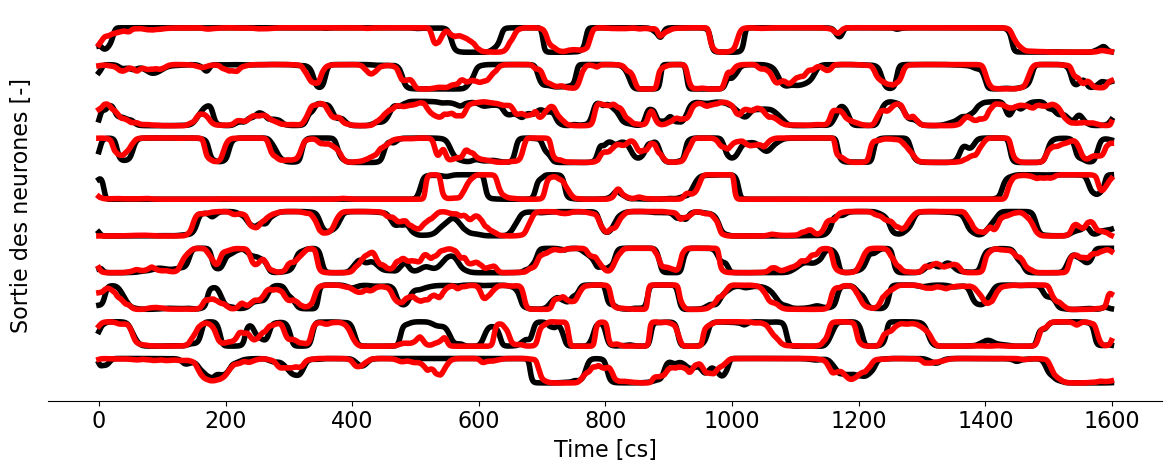

In [50]:
# NUMBA
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
a = 7
teacher = teacher_list[a]
x_list = x_list_teachers[a]
for idx, i in enumerate(range(0,10)) :
    ax1.plot(teacher[i]+(idx)*3, color="black")
    ax1.plot(np.tanh(x_list[i])+(idx)*3, color="red")
ax1.set_xlabel("Time [cs]")
ax1.set_ylabel("Sortie des neurones [-]")
ax1.tick_params(left=False)
ax1.set(yticklabels=[])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

10


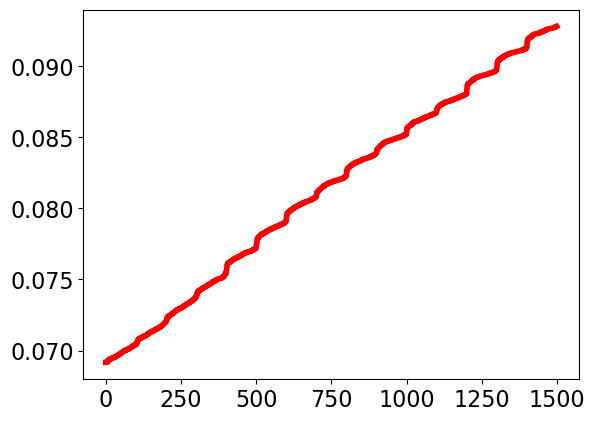

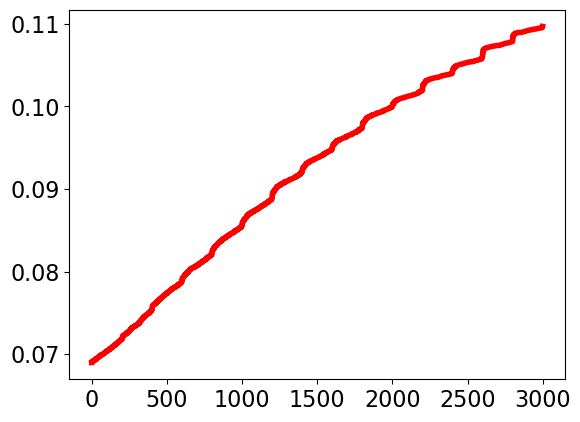

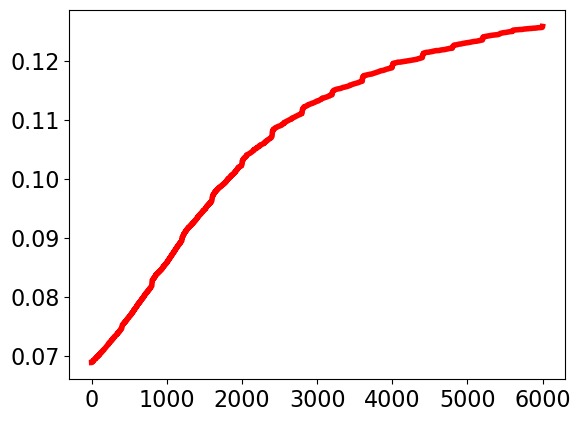

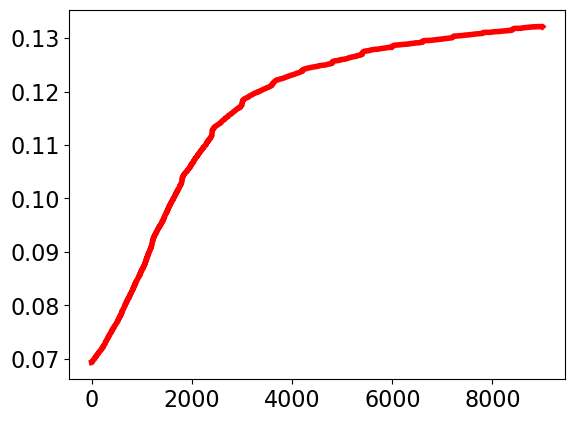

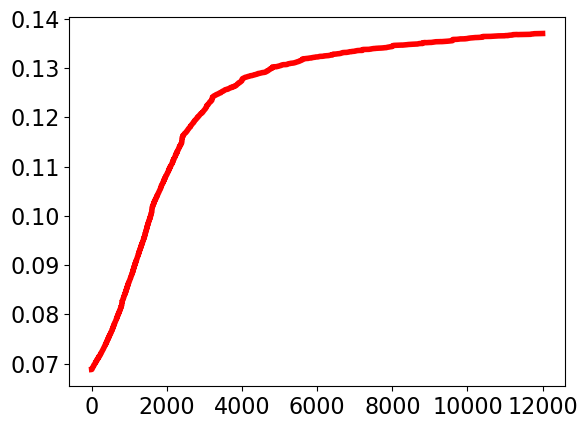

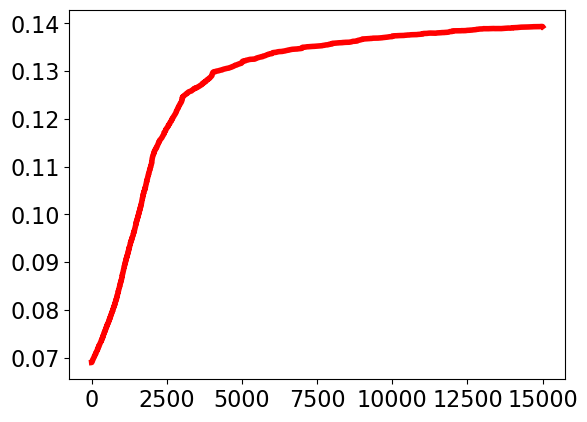

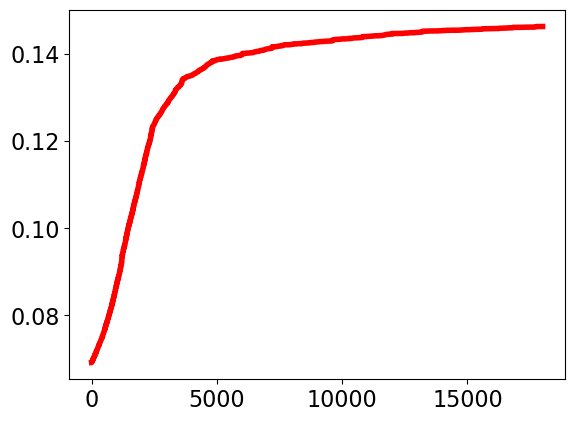

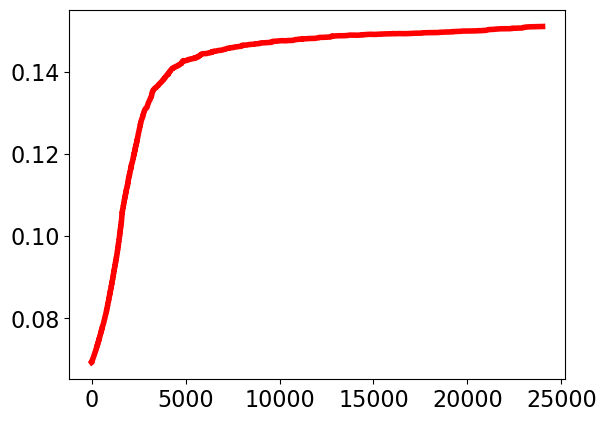

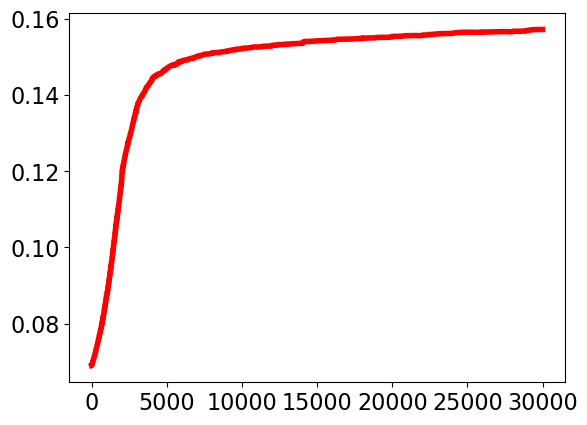

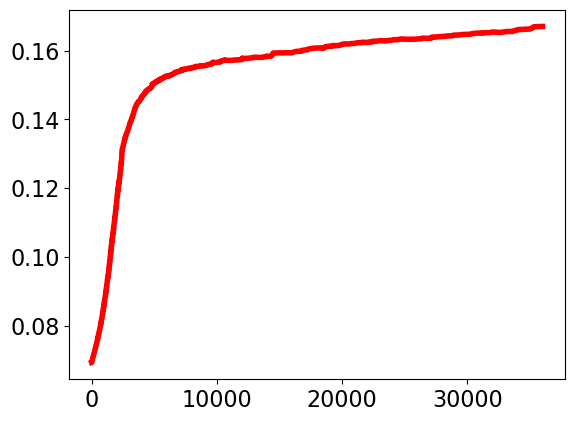

In [57]:
# NUMBA
#fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
print(len(j_mean_list_list))
for i in j_mean_list_list :
    J_abslist = []
    for j in i :
        J_abslist.append(j) 
    plt.plot(J_abslist, color="red")
    plt.show()

In [22]:
J_list_CC = []
J_CC = []
x_list_CC = []
names = [100,200,400,600]
for i in names :
    J_list_CC.append(np.load(f"J_list_{i}.npy"))
    J_CC.append(np.load(f"J_{i}.npy"))
    x_list_CC.append(np.load(f"x_list_{i}.npy"))

In [23]:
#currents_truth = compute_currents(model.J, region_size=100, no_regions=3, activity=teacher)
currents_list = []
for idx, i in enumerate(x_list_CC): 
    currents_list.append(compute_currents(J_CC[idx], region_size=names[idx], no_regions=3, activity=np.tanh(i)))

In [24]:
PCA_list = []
for currents in currents_list:
    pca_RNN = [None] * len(currents)
    for i, curr in enumerate(currents):
        pca = PCA(n_components=2)
        components = pca.fit_transform(curr.T).T
        norm_component = components[0] / max(abs(components[0]))
        pca_RNN[i] = norm_component
    PCA_list.append(pca_RNN)

[0.79456404 0.81675966 0.59252723 1.        ]


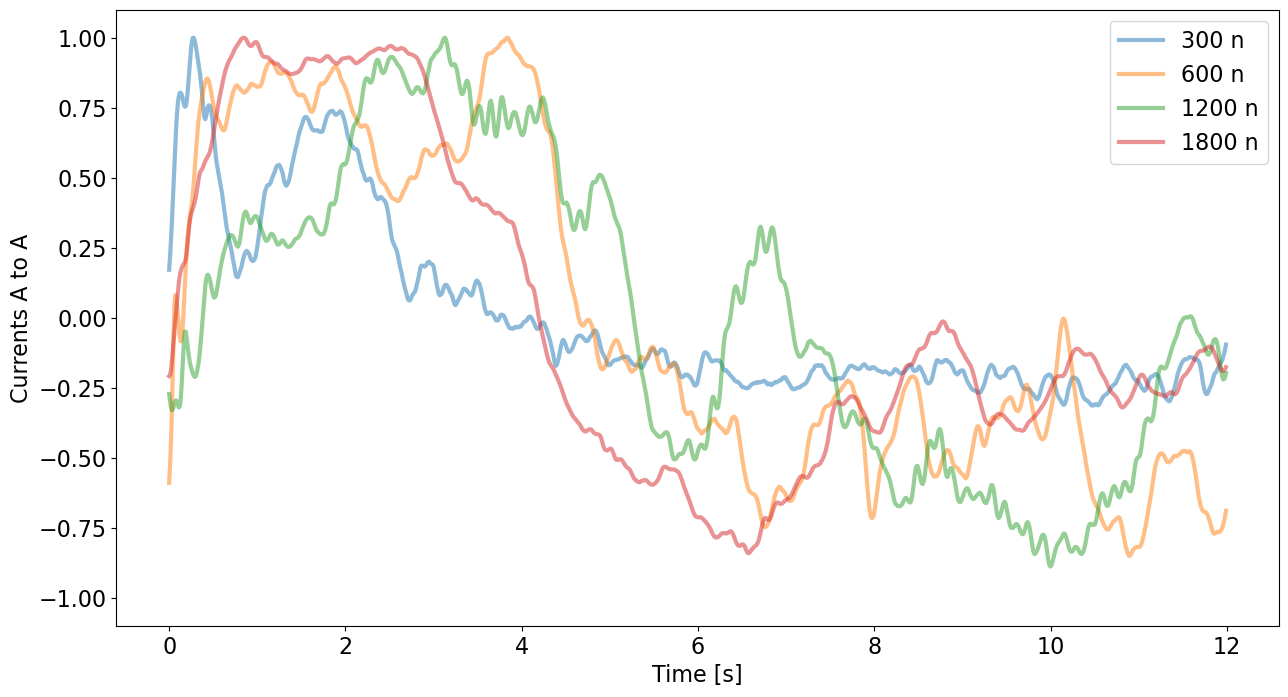

In [59]:
fig, ax = plt.subplots(figsize=(15, 8))
a = 1
#ax.plot(time_list[7], pca_truth[a], label="Data")
print(np.corrcoef((PCA_list[0][a],PCA_list[1][a],PCA_list[2][a],PCA_list[3][a]))[3])
ax.plot(time, PCA_list[0][a], label="300 n", linewidth=3, alpha=0.5)
ax.plot(time, PCA_list[1][a], label="600 n", linewidth=3, alpha=0.5)
ax.plot(time, PCA_list[2][a], label="1200 n", linewidth=3, alpha=0.5)
ax.plot(time, PCA_list[3][a], label="1800 n", linewidth=3, alpha=0.5)
ax.legend()
ax.set_ylim([-1.1, 1.1])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Currents A to A")
plt.show()

## Variabilité des courants en fonction du moyennage (VcurMoy)

In [193]:
def gaussian_blurer(teacher, sigma):
    blurred_teacher = np.zeros_like(teacher.T)
    for idx, i in enumerate(teacher.T) :
        matrix_a = np.reshape(i[:200],(10,20))
        matrix_b= np.reshape(i[200:400],(10,20))
        matrix_c = np.reshape(i[400:],(10,20))
        blurred_matrix_a = gaussian_filter(matrix_a, sigma=sigma,radius=1)
        blurred_matrix_b = gaussian_filter(matrix_b, sigma=sigma,radius=1)
        blurred_matrix_c = gaussian_filter(matrix_c, sigma=sigma,radius=1)
        blurred_data_a =  np.reshape(blurred_matrix_a,(200))
        blurred_data_b =  np.reshape(blurred_matrix_b,(200))
        blurred_data_c =  np.reshape(blurred_matrix_c,(200))
        blurred_teacher_vector = np.concatenate((blurred_data_a,blurred_data_b, blurred_data_c), axis=0)
        blurred_teacher[idx] = blurred_teacher_vector/abs(max(blurred_teacher_vector))
    return blurred_teacher.T

In [122]:
model = GeneratorModel3R(N=200, g_AB=[1.8, 1.5, 1.5], w_rgn=0.01, p_rgn=0.01)
time = np.arange(0.0, 12.0, 0.01)

#rA, rB, rC = model.integrate(time=time)
#np.save("3R_rA_600_VcurMoy.npy", rA)
#np.save("3R_rB_600_VcurMoy.npy", rB)
#np.save("3R_rC_600_VcurMoy.npy", rC)
#np.save("3R_modelJ_600_VcurMoy.npy", model.J)

rA = np.load("3R_rA_600_VcurMoy.npy")
rB = np.load("3R_rB_600_VcurMoy.npy")
rC = np.load("3R_rC_600_VcurMoy.npy")
model.J = np.load("3R_modelJ_600_VcurMoy.npy")

In [144]:
# On défini un network hors classe

# D'abord quelques constantes
N = 600 # Nombre de neurones
tau = 0.1 # Pas de temps
alpha = 1.0 # Valeur du bruit initial sur la diagonale de P
g = 1.5 # Constante de force des connections récurentes
J_list = []


# Ensuite quelques vecteurs et matrices
J = np.random.normal(loc=0.0, scale=g/np.sqrt(N), size=(N, N)) 
P = 1/alpha * np.identity(n=N)
x_vector = np.random.uniform(low=-1.0, high=1.0, size=(N, 1))
h = np.random.uniform(low=-1.0, high=1.0, size=(N, 1))

# On définie le teacher
teacher = np.concatenate((np.tanh(rA), np.tanh(rB), np.tanh(rC)), axis=0)

In [ ]:
sigma_list = [0.6,0.8,1,1.2,1.4]
j_list_blur = []
x_list_blur = []

for j in tqdm(sigma_list) :
    # C'est parti pour le learning
    blurred_teacher = gaussian_blurer(teacher, j)
    for i in range(10):
        x_vector, x_list, J, J_mean, P = learn(N, x_vector, time, blurred_teacher, tau, g, J, h, P)
        J_list.append(J_mean)
    j_list_blur.append(J)
    x_list_blur.append(x_list)

np.save("j_list_blur_600_VcurMoy.npy", j_list_blur)
np.save("x_list_blur_600_VcurMoy.npy", x_list_blur)
# On save sous forme de .npy
np.save("3R_training_numba_600_VcurMoy.npy", J_list)
np.save("3R_netJ_numba_600_VcurMoy.npy", J)
np.save("3R_x_numba_600_VcurMoy.npy", x_list)

 20%|████████████████▍                                                                 | 1/5 [01:46<07:05, 106.38s/it]

In [1]:
aa = np.empty((10,10))
blurred_teacher = gaussian_blurer(teacher, 0.6)
print(blurred_teacher-teacher) 
fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].imshow(blurred_teacher,aspect='auto')
ax[1].imshow(teacher,aspect='auto')
plt.show()

NameError: name 'np' is not defined

In [129]:
# NUMBA
J_list = np.load("3R_training_numba_600_VcurMoy.npy")
J = np.load("3R_netJ_numba_600_VcurMoy.npy")
x_list = np.load("3R_x_numba_600_VcurMoy.npy")

In [153]:
# NUMBA
j_list_blur = np.load("j_list_blur_600_VcurMoy.npy")
x_list_blur = np.load("x_list_blur_600_VcurMoy.npy")
print(x_list_blur.shape)

(5, 600, 1200)


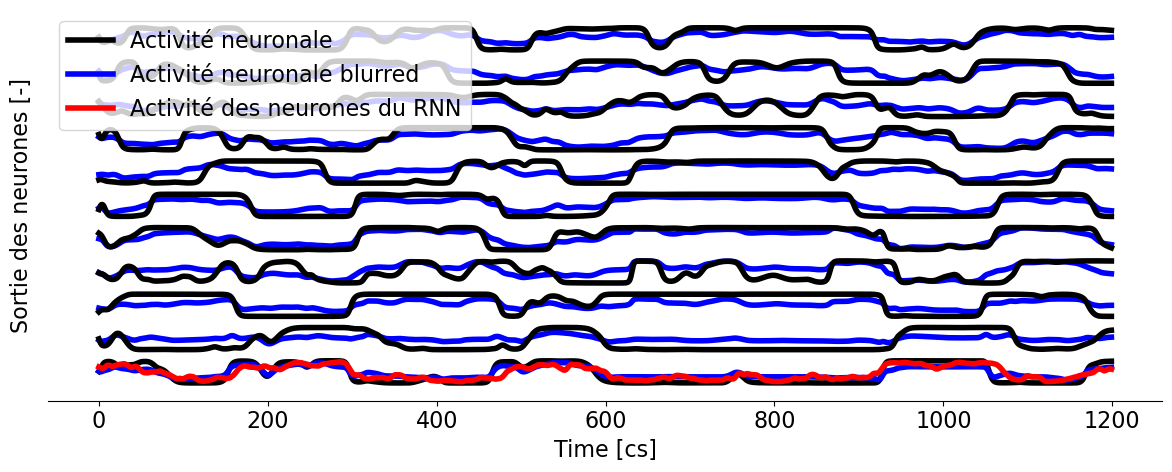

In [152]:
# NUMBA
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
ax1.plot(teacher[0], color="black", label='Activité neuronale')
ax1.plot(blurred_teacher[0], color="blue", label='Activité neuronale blurred')
ax1.plot(np.tanh(x_list_blur[0][0]), color="red", label='Activité des neurones du RNN')
for idx, i in enumerate(range(0,10)) :
    ax1.plot(blurred_teacher[i+1]+(idx+1)*3, color="blue")
    ax1.plot(teacher[i+1]+(idx+1)*3, color="black")
    ax1.plot(np.tanh(x_list[0][i+1])+(idx+1)*3, color="red")
ax1.set_xlabel("Time [cs]")
ax1.set_ylabel("Sortie des neurones [-]")
ax1.tick_params(left=False)
ax1.set(yticklabels=[])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

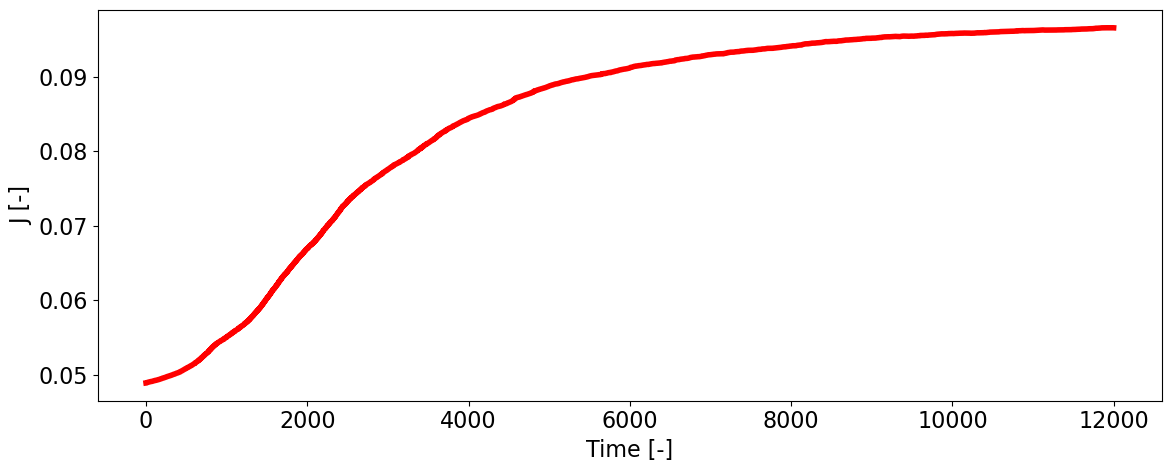

In [131]:
# NUMBA
fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
J_abslist = []
for i in J_list :
    for j in i :
        J_abslist.append(j) 
ax1.plot(J_abslist, color="red")
ax1.set_xlabel("Time [-]")
ax1.set_ylabel("J [-]")

plt.tight_layout()
plt.show()

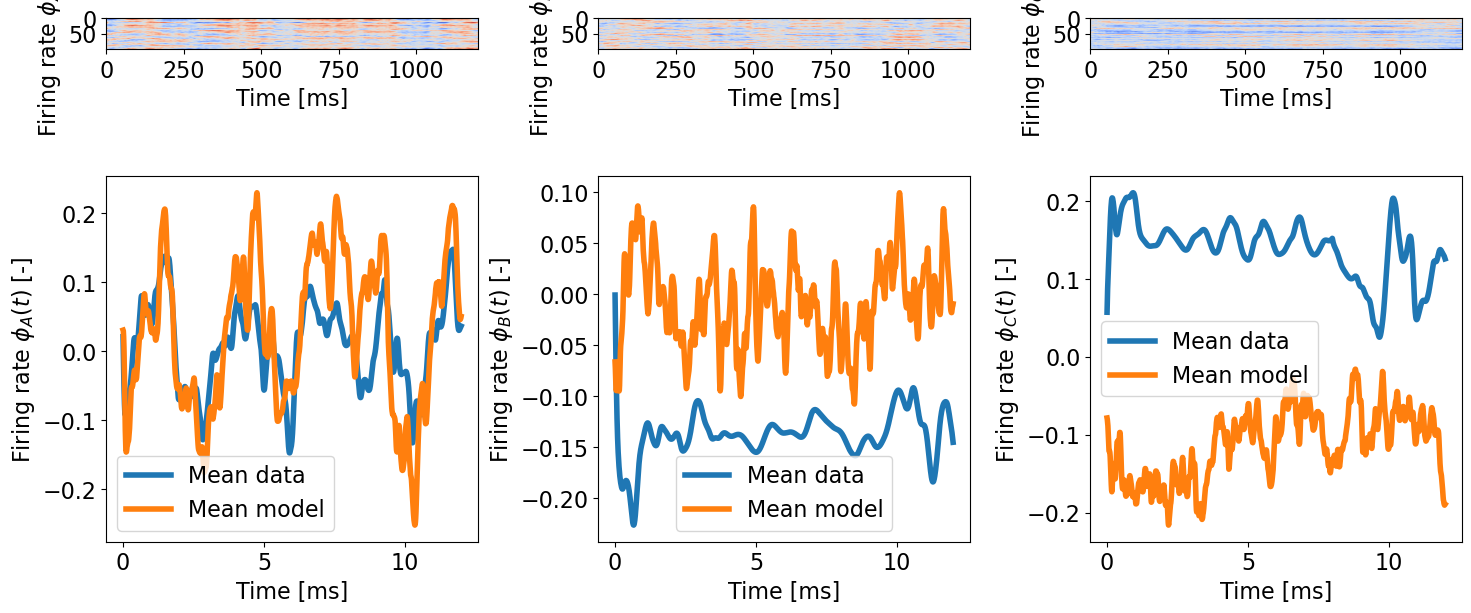

In [134]:
N = 300
modelA, modelB, modelC = x_list[:100, :], x_list[100:200, :], x_list[200:300, :]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 8))

ax1.imshow(np.tanh(modelA), cmap=cmap, vmin=-1.0, vmax=1.0)
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Firing rate $\phi_A(t)$ [-]")

ax2.imshow(np.tanh(modelB), cmap=cmap, vmin=-1.0, vmax=1.0)
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Firing rate $\phi_B(t)$ [-]") 

ax3.imshow(np.tanh(modelC), cmap=cmap, vmin=-1.0, vmax=1.0)
ax3.set_xlabel("Time [ms]")
ax3.set_ylabel("Firing rate $\phi_C(t)$ [-]") 

ax4.plot(time, np.mean(np.tanh(rA), axis=0), label="Mean data")
ax4.plot(time, np.mean(np.tanh(modelA), axis=0), label="Mean model")
ax4.legend()
ax4.set_xlabel("Time [ms]")
ax4.set_ylabel("Firing rate $\phi_A(t)$ [-]")

ax5.plot(time, np.mean(np.tanh(rB), axis=0), label="Mean data")
ax5.plot(time, np.mean(np.tanh(modelB), axis=0), label="Mean model")
ax5.legend()
ax5.set_xlabel("Time [ms]")
ax5.set_ylabel("Firing rate $\phi_B(t)$ [-]")

ax6.plot(time, np.mean(np.tanh(rC), axis=0), label="Mean data")
ax6.plot(time, np.mean(np.tanh(modelC), axis=0), label="Mean model")
ax6.legend()
ax6.set_xlabel("Time [ms]")
ax6.set_ylabel("Firing rate $\phi_C(t)$ [-]")

plt.tight_layout()
plt.show()

In [157]:
currents_truth = compute_currents(model.J, region_size=100, no_regions=3, activity=teacher)
currents_list = []
for idx, i in enumerate(x_list_blur): 
    currents_list.append(compute_currents(j_list_blur[idx], region_size=100, no_regions=3, activity=np.tanh(i)))

In [158]:
PCA_list = []
for currents in currents_list:
    pca_RNN = [None] * len(currents)
    for i, curr in enumerate(currents):
        pca = PCA(n_components=2)
        components = pca.fit_transform(curr.T).T
        norm_component = components[0] / max(abs(components[0]))
        pca_RNN[i] = norm_component
    PCA_list.append(pca_RNN)
    
pca_truth = [None] * len(currents_truth)
for i, curr in enumerate(currents_truth):
    pca = PCA(n_components=2)
    components = pca.fit_transform(curr.T).T
    norm_component = components[0] / max(abs(components[0]))
    pca_truth[i] = norm_component

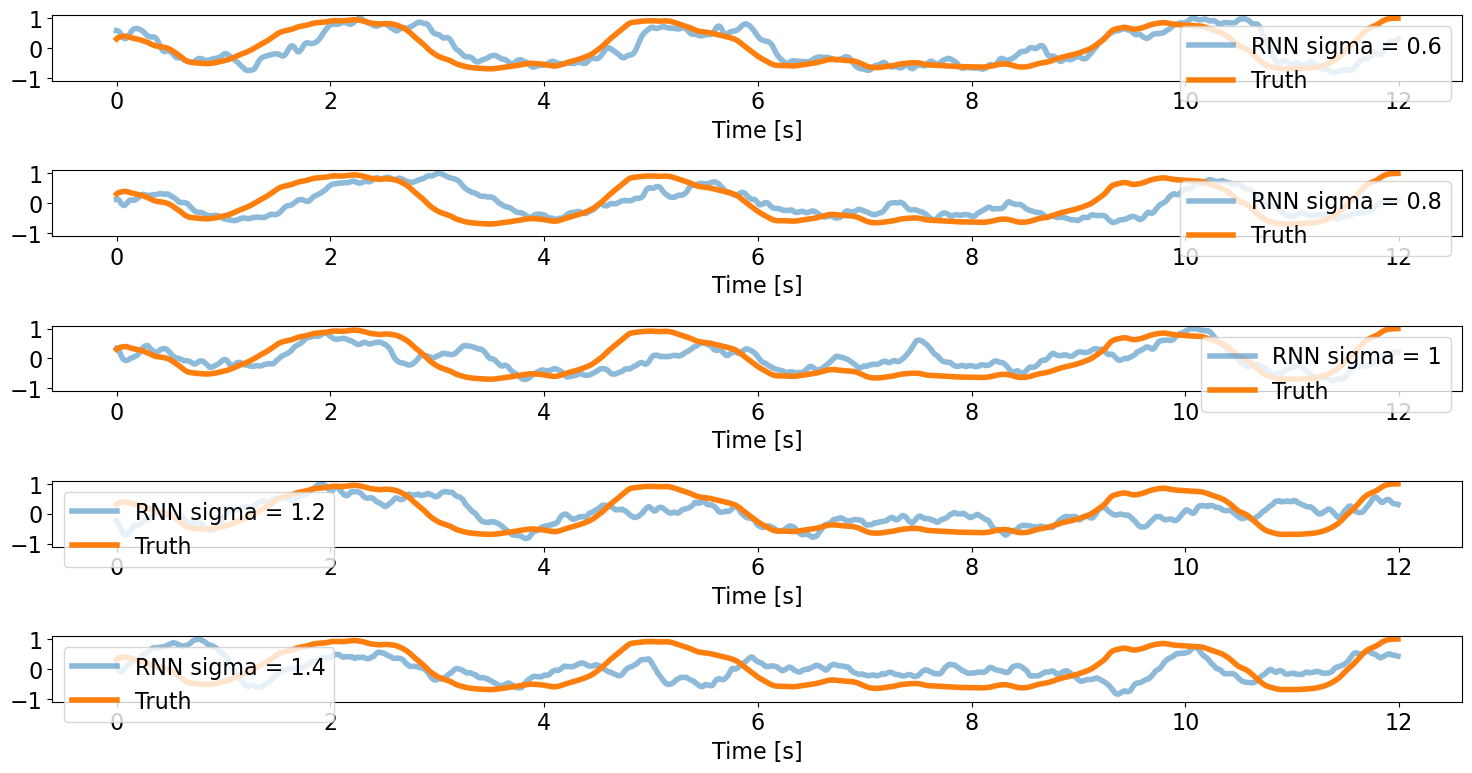

In [187]:
fig, ax = plt.subplots(5, 1, figsize=(15, 8))
labels = ["RNN sigma = 0.6","RNN sigma = 0.8","RNN sigma = 1","RNN sigma = 1.2","RNN sigma = 1.4"]
for i in range(5):
    ax[i].plot(time, PCA_list[i][0],  alpha=0.5, label=labels[i])
    ax[i].plot(time, pca_truth[0], label="Truth")
    ax[i].set_ylim([-1.1, 1.1])
    ax[i].legend()
    ax[i].set_xlabel("Time [s]")
    #ax[i].set_ylabel("Currents A to A")
plt.tight_layout()
plt.show()

### Subsampling analysis

In [128]:
for arr in J_loop_list:
    moy = np.mean(arr)
    plt.imshow(arr,label='BLABLA')
    plt.title(f'Matrice de connectivité  $J$,\n Moyenne = {moy:.5f} ')
    plt.colorbar()
    plt.show()

In [ ]:
n = 300
teacher = np.concatenate((np.tanh(rA), np.tanh(rB), np.tanh(rC)), axis=0)
currents_truth = compute_currents(network=model, region_size=1000, no_regions=3, activity=teacher)
pca_truth = [None] * len(currents_truth)
for i, curr in enumerate(currents_truth):
    pca = PCA(n_components=2)
    components = pca.fit_transform(curr.T).T
    norm_component = components[0] / max(abs(components[0]))
    pca_truth[i] = norm_component

N_trials = 5
all_pca_RNN = [np.empty((N_trials, 1200)) for i in range(9)]
for trial in range(N_trials):
    net = Network(N=n, tau=0.1, alpha=1.0)
    indices = np.random.choice(3000, size=n, replace=False)
    subset = teacher[indices]
    for i in tqdm(range(50)):
        x, J = net.learn(time, subset)
    currents = compute_currents(network=net, region_size=n//3, no_regions=3, activity=np.tanh(x))
    
    for i, curr in enumerate(currents):
        pca = PCA(n_components=2)
        components = pca.fit_transform(curr.T).T
        norm_component = components[0] / max(abs(components[0]))
        all_pca_RNN[i][trial, :] = norm_component[:]

np.save("CURBdata/3R_allPCA_n{}".format(n), all_pca_RNN)

In [ ]:
teacher = np.concatenate((np.tanh(rA), np.tanh(rB), np.tanh(rC)), axis=0)
currents_truth = compute_currents(network=model, region_size=1000, no_regions=3, activity=teacher)
pca_truth = [None] * len(currents_truth)
for i, curr in enumerate(currents_truth):
    pca = PCA(n_components=2)
    components = pca.fit_transform(curr.T).T
    norm_component = components[0] / max(abs(components[0]))
    pca_truth[i] = norm_component

all_pca_RNN = np.load("CURBdata/3R_allPCA_n300.npy")
for i, pca in enumerate(all_pca_RNN):
    truth = pca_truth[i]
    for j, trial in enumerate(pca):
        diff_pos = np.sum((trial - truth)**2)
        diff_neg = np.sum((-trial - truth)**2)
        if diff_pos > diff_neg:
            all_pca_RNN[i][j] = -trial

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 8))

mean, std = np.mean(all_pca_RNN[0], axis=0), np.std(all_pca_RNN[0], axis=0)
ax[0][0].fill_between(time, y1=mean-std, y2=mean+std, alpha=0.2)
ax[0][0].plot(time, mean, label="RNN")
ax[0][0].plot(time, pca_truth[0], label="Truth")
# ax[0][0].legend()
ax[0][0].set_ylim([-1.1, 1.1])
ax[0][0].set_xlabel("Time [s]")
ax[0][0].set_ylabel("Currents A to A")

mean, std = np.mean(all_pca_RNN[1], axis=0), np.std(all_pca_RNN[1], axis=0)
ax[0][1].fill_between(time, y1=mean-std, y2=mean+std, alpha=0.2)
ax[0][1].plot(time, mean, label="RNN")
ax[0][1].plot(time, pca_truth[1], label="Truth")
# ax[0][1].legend()
ax[0][1].set_ylim([-1.1, 1.1])
ax[0][1].set_xlabel("Time [s]")
ax[0][1].set_ylabel("Currents B to A")

mean, std = np.mean(all_pca_RNN[2], axis=0), np.std(all_pca_RNN[2], axis=0)
ax[0][2].fill_between(time, y1=mean-std, y2=mean+std, alpha=0.2)
ax[0][2].plot(time, mean, label="RNN")
ax[0][2].plot(time, pca_truth[2], label="Truth")
# ax[0][2].legend()
ax[0][2].set_ylim([-1.1, 1.1])
ax[0][2].set_xlabel("Time [s]")
ax[0][2].set_ylabel("Currents C to A")

mean, std = np.mean(all_pca_RNN[3], axis=0), np.std(all_pca_RNN[3], axis=0)
ax[1][0].fill_between(time, y1=mean-std, y2=mean+std, alpha=0.2)
ax[1][0].plot(time, mean, label="RNN")
ax[1][0].plot(time, pca_truth[3], label="Truth")
# ax[1][0].legend()
ax[1][0].set_ylim([-1.1, 1.1])
ax[1][0].set_xlabel("Time [s]")
ax[1][0].set_ylabel("Currents A to B")

mean, std = np.mean(all_pca_RNN[4], axis=0), np.std(all_pca_RNN[4], axis=0)
ax[1][1].fill_between(time, y1=mean-std, y2=mean+std, alpha=0.2)
ax[1][1].plot(time, mean, label="RNN")
ax[1][1].plot(time, pca_truth[4], label="Truth")
# ax[1][1].legend()
ax[1][1].set_ylim([-1.1, 1.1])
ax[1][1].set_xlabel("Time [s]")
ax[1][1].set_ylabel("Currents B to B")

mean, std = np.mean(all_pca_RNN[5], axis=0), np.std(all_pca_RNN[5], axis=0)
ax[1][2].fill_between(time, y1=mean-std, y2=mean+std, alpha=0.2)
ax[1][2].plot(time, mean, label="RNN")
ax[1][2].plot(time, pca_truth[5], label="Truth")
# ax[1][2].legend()
ax[1][2].set_ylim([-1.1, 1.1])
ax[1][2].set_xlabel("Time [s]")
ax[1][2].set_ylabel("Currents C to B")

mean, std = np.mean(all_pca_RNN[6], axis=0), np.std(all_pca_RNN[6], axis=0)
ax[2][0].fill_between(time, y1=mean-std, y2=mean+std, alpha=0.2)
ax[2][0].plot(time, mean, label="RNN")
ax[2][0].plot(time, pca_truth[6], label="Truth")
# ax[2][0].legend()
ax[2][0].set_ylim([-1.1, 1.1])
ax[2][0].set_xlabel("Time [s]")
ax[2][0].set_ylabel("Currents A to C")

mean, std = np.mean(all_pca_RNN[7], axis=0), np.std(all_pca_RNN[7], axis=0)
ax[2][1].fill_between(time, y1=mean-std, y2=mean+std, alpha=0.2)
ax[2][1].plot(time, mean, label="RNN")
ax[2][1].plot(time, pca_truth[7], label="Truth")
# ax[2][1].legend()
ax[2][1].set_ylim([-1.1, 1.1])
ax[2][1].set_xlabel("Time [s]")
ax[2][1].set_ylabel("Currents B to C")

mean, std = np.mean(all_pca_RNN[8], axis=0), np.std(all_pca_RNN[8], axis=0)
ax[2][2].fill_between(time, y1=mean-std, y2=mean+std, alpha=0.2)
ax[2][2].plot(time, mean, label="RNN")
ax[2][2].plot(time, pca_truth[8], label="Truth")
# ax[2][2].legend()
ax[2][2].set_ylim([-1.1, 1.1])
ax[2][2].set_xlabel("Time [s]")
ax[2][2].set_ylabel("Currents C to C")

plt.tight_layout()
plt.show()

NameError: name 'pca_truth0' is not defined

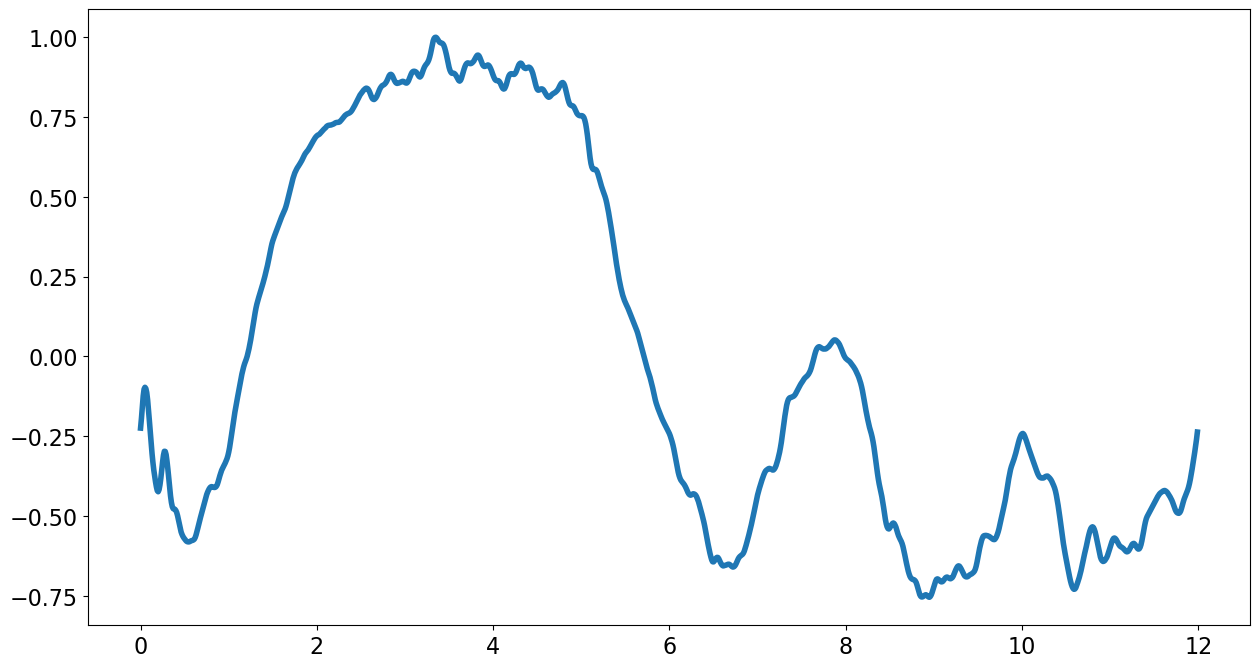

In [51]:
fig, ax = plt.subplots(figsize=(15, 8))
a = 0
ax.plot(time, pca_RNN[a], label="Data")
ax.plot(time, pca_truth0[a], label="RNN 0", linewidth=3,linestyle='--', alpha=0.5)
ax.plot(time, pca_truth1[a], label="RNN 1", linewidth=3,linestyle='--', alpha=0.5)
ax.plot(time, pca_truth2[a], label="RNN 2", linewidth=3,linestyle='--', alpha=0.5)
ax.plot(time, pca_truth3[a], label="RNN 3", linewidth=3,linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim([-1.1, 1.1])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Currents A to A")
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 8))

mean = np.mean(all_pca_RNN[0], axis=0)
ax[0][0].plot(time, all_pca_RNN[0].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[0][0].plot(time, mean, label="RNN")
ax[0][0].plot(time, pca_truth[0], label="Truth")
# ax[0][0].legend()
ax[0][0].set_ylim([-1.1, 1.1])
ax[0][0].set_xlabel("Time [s]")
ax[0][0].set_ylabel("Currents A to A")

mean = np.mean(all_pca_RNN[1], axis=0)
ax[0][1].plot(time, all_pca_RNN[1].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[0][1].plot(time, mean, label="RNN")
ax[0][1].plot(time, pca_truth[1], label="Truth")
# ax[0][1].legend()
ax[0][1].set_ylim([-1.1, 1.1])
ax[0][1].set_xlabel("Time [s]")
ax[0][1].set_ylabel("Currents B to A")

mean = np.mean(all_pca_RNN[2], axis=0)
ax[0][2].plot(time, all_pca_RNN[2].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[0][2].plot(time, mean, label="RNN")
ax[0][2].plot(time, pca_truth[2], label="Truth")
# ax[0][2].legend()
ax[0][2].set_ylim([-1.1, 1.1])
ax[0][2].set_xlabel("Time [s]")
ax[0][2].set_ylabel("Currents C to A")

mean = np.mean(all_pca_RNN[3], axis=0)
ax[1][0].plot(time, all_pca_RNN[3].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[1][0].plot(time, mean, label="RNN")
ax[1][0].plot(time, pca_truth[3], label="Truth")
# ax[1][0].legend()
ax[1][0].set_ylim([-1.1, 1.1])
ax[1][0].set_xlabel("Time [s]")
ax[1][0].set_ylabel("Currents A to B")

mean = np.mean(all_pca_RNN[4], axis=0)
ax[1][1].plot(time, all_pca_RNN[4].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[1][1].plot(time, mean, label="RNN")
ax[1][1].plot(time, pca_truth[4], label="Truth")
# ax[1][1].legend()
ax[1][1].set_ylim([-1.1, 1.1])
ax[1][1].set_xlabel("Time [s]")
ax[1][1].set_ylabel("Currents B to B")

mean = np.mean(all_pca_RNN[5], axis=0)
ax[1][2].plot(time, all_pca_RNN[5].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[1][2].plot(time, mean, label="RNN")
ax[1][2].plot(time, pca_truth[5], label="Truth")
# ax[1][2].legend()
ax[1][2].set_ylim([-1.1, 1.1])
ax[1][2].set_xlabel("Time [s]")
ax[1][2].set_ylabel("Currents C to B")

mean = np.mean(all_pca_RNN[6], axis=0)
ax[2][0].plot(time, all_pca_RNN[6].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[2][0].plot(time, mean, label="RNN")
ax[2][0].plot(time, pca_truth[6], label="Truth")
# ax[2][0].legend()
ax[2][0].set_ylim([-1.1, 1.1])
ax[2][0].set_xlabel("Time [s]")
ax[2][0].set_ylabel("Currents A to C")

mean = np.mean(all_pca_RNN[7], axis=0)
ax[2][1].plot(time, all_pca_RNN[7].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[2][1].plot(time, mean, label="RNN")
ax[2][1].plot(time, pca_truth[7], label="Truth")
# ax[2][1].legend()
ax[2][1].set_ylim([-1.1, 1.1])
ax[2][1].set_xlabel("Time [s]")
ax[2][1].set_ylabel("Currents B to C")

mean = np.mean(all_pca_RNN[8], axis=0)
ax[2][2].plot(time, all_pca_RNN[8].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[2][2].plot(time, mean, label="RNN")
ax[2][2].plot(time, pca_truth[8], label="Truth")
# ax[2][2].legend()
ax[2][2].set_ylim([-1.1, 1.1])
ax[2][2].set_xlabel("Time [s]")
ax[2][2].set_ylabel("Currents C to C")

plt.tight_layout()
plt.show()

In [ ]:
n = 300
teacher = np.concatenate((np.tanh(rA), np.tanh(rB), np.tanh(rC)), axis=0)
currents_truth = compute_currents(network=model, region_size=1000, no_regions=3, activity=teacher)
pca_truth = [None] * len(currents_truth)
for i, curr in enumerate(currents_truth):
    pca = PCA(n_components=2)
    components = pca.fit_transform(curr.T).T
    norm_component = components[0] / max(abs(components[0]))
    pca_truth[i] = norm_component

N_trials = 25
indices = np.random.choice(3000, size=n, replace=False)
subset = teacher[indices]
all_pca_RNN = [np.empty((N_trials, 1200)) for i in range(9)]
for trial in range(N_trials):
    net = Network(N=n, tau=0.1, alpha=1.0)
    for i in tqdm(range(50)):
        x, J = net.learn(time, subset)
    currents = compute_currents(network=net, region_size=n//3, no_regions=3, activity=np.tanh(x))
    
    for i, curr in enumerate(currents):
        pca = PCA(n_components=2)
        components = pca.fit_transform(curr.T).T
        norm_component = components[0] / max(abs(components[0]))
        all_pca_RNN[i][trial, :] = norm_component[:]

np.save("CURBdata/3R_allPCA_fixn{}".format(n), all_pca_RNN)

In [ ]:
teacher = np.concatenate((np.tanh(rA), np.tanh(rB), np.tanh(rC)), axis=0)
currents_truth = compute_currents(network=model, region_size=1000, no_regions=3, activity=teacher)
pca_truth = [None] * len(currents_truth)
for i, curr in enumerate(currents_truth):
    pca = PCA(n_components=2)
    components = pca.fit_transform(curr.T).T
    norm_component = components[0] / max(abs(components[0]))
    pca_truth[i] = norm_component

all_pca_RNN = np.load("CURBdata/3R_allPCA_fixn300.npy")
for i, pca in enumerate(all_pca_RNN):
    truth = pca_truth[i]
    for j, trial in enumerate(pca):
        diff_pos = np.sum((trial - truth)**2)
        diff_neg = np.sum((-trial - truth)**2)
        if diff_pos > diff_neg:
            all_pca_RNN[i][j] = -trial

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 8))

mean = np.mean(all_pca_RNN[0], axis=0)
ax[0][0].plot(time, all_pca_RNN[0].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[0][0].plot(time, mean, label="RNN")
ax[0][0].plot(time, pca_truth[0], label="Truth")
# ax[0][0].legend()
ax[0][0].set_ylim([-1.1, 1.1])
ax[0][0].set_xlabel("Time [s]")
ax[0][0].set_ylabel("Currents A to A")

mean = np.mean(all_pca_RNN[1], axis=0)
ax[0][1].plot(time, all_pca_RNN[1].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[0][1].plot(time, mean, label="RNN")
ax[0][1].plot(time, pca_truth[1], label="Truth")
# ax[0][1].legend()
ax[0][1].set_ylim([-1.1, 1.1])
ax[0][1].set_xlabel("Time [s]")
ax[0][1].set_ylabel("Currents B to A")

mean = np.mean(all_pca_RNN[2], axis=0)
ax[0][2].plot(time, all_pca_RNN[2].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[0][2].plot(time, mean, label="RNN")
ax[0][2].plot(time, pca_truth[2], label="Truth")
# ax[0][2].legend()
ax[0][2].set_ylim([-1.1, 1.1])
ax[0][2].set_xlabel("Time [s]")
ax[0][2].set_ylabel("Currents C to A")

mean = np.mean(all_pca_RNN[3], axis=0)
ax[1][0].plot(time, all_pca_RNN[3].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[1][0].plot(time, mean, label="RNN")
ax[1][0].plot(time, pca_truth[3], label="Truth")
# ax[1][0].legend()
ax[1][0].set_ylim([-1.1, 1.1])
ax[1][0].set_xlabel("Time [s]")
ax[1][0].set_ylabel("Currents A to B")

mean = np.mean(all_pca_RNN[4], axis=0)
ax[1][1].plot(time, all_pca_RNN[4].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[1][1].plot(time, mean, label="RNN")
ax[1][1].plot(time, pca_truth[4], label="Truth")
# ax[1][1].legend()
ax[1][1].set_ylim([-1.1, 1.1])
ax[1][1].set_xlabel("Time [s]")
ax[1][1].set_ylabel("Currents B to B")

mean = np.mean(all_pca_RNN[5], axis=0)
ax[1][2].plot(time, all_pca_RNN[5].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[1][2].plot(time, mean, label="RNN")
ax[1][2].plot(time, pca_truth[5], label="Truth")
# ax[1][2].legend()
ax[1][2].set_ylim([-1.1, 1.1])
ax[1][2].set_xlabel("Time [s]")
ax[1][2].set_ylabel("Currents C to B")

mean = np.mean(all_pca_RNN[6], axis=0)
ax[2][0].plot(time, all_pca_RNN[6].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[2][0].plot(time, mean, label="RNN")
ax[2][0].plot(time, pca_truth[6], label="Truth")
# ax[2][0].legend()
ax[2][0].set_ylim([-1.1, 1.1])
ax[2][0].set_xlabel("Time [s]")
ax[2][0].set_ylabel("Currents A to C")

mean = np.mean(all_pca_RNN[7], axis=0)
ax[2][1].plot(time, all_pca_RNN[7].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[2][1].plot(time, mean, label="RNN")
ax[2][1].plot(time, pca_truth[7], label="Truth")
# ax[2][1].legend()
ax[2][1].set_ylim([-1.1, 1.1])
ax[2][1].set_xlabel("Time [s]")
ax[2][1].set_ylabel("Currents B to C")

mean = np.mean(all_pca_RNN[8], axis=0)
ax[2][2].plot(time, all_pca_RNN[8].T, color="tab:blue", linewidth=1, alpha=0.5)
ax[2][2].plot(time, mean, label="RNN")
ax[2][2].plot(time, pca_truth[8], label="Truth")
# ax[2][2].legend()
ax[2][2].set_ylim([-1.1, 1.1])
ax[2][2].set_xlabel("Time [s]")
ax[2][2].set_ylabel("Currents C to C")

plt.tight_layout()
plt.show()

### Coarse resolution analysis

In [ ]:
def sum_by_bunch(array, M):
    N, T = array.shape
    bunch_size = N // M
    remainder = N % M
    bunch_sizes = [bunch_size] * M
    for i in range(remainder):
        bunch_sizes[i] += 1
    output = np.zeros((M, T))
    idx = 0
    for bunch_size in bunch_sizes:
        output[idx] = np.mean(array[idx* bunch_size:(idx + 1)*bunch_size], axis=0)
        idx += 1
    return output

In [ ]:
teacher = np.concatenate((np.tanh(rA), np.tanh(rB), np.tanh(rC)), axis=0)
currents_truth = compute_currents(network=model, region_size=1000, no_regions=3, activity=teacher)
pca_truth = [None] * len(currents_truth)
for i, curr in enumerate(currents_truth):
    pca = PCA(n_components=2)
    components = pca.fit_transform(curr.T).T
    norm_component = components[0] / max(abs(components[0]))
    pca_truth[i] = norm_component

In [ ]:
gr = 1500
subset = sum_by_bunch(teacher, gr)
net = Network(N=gr, tau=0.1, alpha=1.0)
for i in tqdm(range(50)):
    x, J = net.learn(time, subset)
    
currents_RNN = compute_currents(network=net, region_size=gr//3, no_regions=3, activity=np.tanh(x))
pca_RNN = np.empty((len(currents_RNN), len(time))) 
for i, curr in enumerate(currents_RNN):
    pca = PCA(n_components=2)
    components = pca.fit_transform(curr.T).T
    norm_component = components[0] / max(abs(components[0]))
    pca_RNN[i, :] = norm_component

np.save("CURBdata/3R_PCA_gr{}".format(gr), pca_RNN)

In [ ]:
pca_RNN = np.load("CURBdata/3R_PCA_gr300.npy")
fig, ax = plt.subplots(3, 3, figsize=(15, 8))

ax[0][0].plot(time, pca_RNN[0], label="RNN")
ax[0][0].plot(time, pca_truth[0], label="Truth")
# ax[0][0].legend()
ax[0][0].set_ylim([-1.1, 1.1])
ax[0][0].set_xlabel("Time [s]")
ax[0][0].set_ylabel("Currents A to A")

ax[0][1].plot(time, -pca_RNN[1], label="RNN")
ax[0][1].plot(time, pca_truth[1], label="Truth")
# ax[0][1].legend()
ax[0][1].set_ylim([-1.1, 1.1])
ax[0][1].set_xlabel("Time [s]")
ax[0][1].set_ylabel("Currents B to A")

ax[0][2].plot(time, pca_RNN[2], label="RNN")
ax[0][2].plot(time, pca_truth[2], label="Truth")
# ax[0][2].legend()
ax[0][2].set_ylim([-1.1, 1.1])
ax[0][2].set_xlabel("Time [s]")
ax[0][2].set_ylabel("Currents C to A")

ax[1][0].plot(time, -pca_RNN[3], label="RNN")
ax[1][0].plot(time, pca_truth[3], label="Truth")
# ax[1][0].legend()
ax[1][0].set_ylim([-1.1, 1.1])
ax[1][0].set_xlabel("Time [s]")
ax[1][0].set_ylabel("Currents A to B")

ax[1][1].plot(time, -pca_RNN[4], label="RNN")
ax[1][1].plot(time, pca_truth[4], label="Truth")
# ax[1][1].legend()
ax[1][1].set_ylim([-1.1, 1.1])
ax[1][1].set_xlabel("Time [s]")
ax[1][1].set_ylabel("Currents B to B")

ax[1][2].plot(time, pca_RNN[5], label="RNN")
ax[1][2].plot(time, pca_truth[5], label="Truth")
# ax[1][2].legend()
ax[1][2].set_ylim([-1.1, 1.1])
ax[1][2].set_xlabel("Time [s]")
ax[1][2].set_ylabel("Currents C to B")

ax[2][0].plot(time, pca_RNN[6], label="RNN")
ax[2][0].plot(time, pca_truth[6], label="Truth")
# ax[2][0].legend()
ax[2][0].set_ylim([-1.1, 1.1])
ax[2][0].set_xlabel("Time [s]")
ax[2][0].set_ylabel("Currents A to C")

ax[2][1].plot(time, pca_RNN[7], label="RNN")
ax[2][1].plot(time, pca_truth[7], label="Truth")
# ax[2][1].legend()
ax[2][1].set_ylim([-1.1, 1.1])
ax[2][1].set_xlabel("Time [s]")
ax[2][1].set_ylabel("Currents B to C")

ax[2][2].plot(time, pca_RNN[8], label="RNN")
ax[2][2].plot(time, pca_truth[8], label="Truth")
# ax[2][2].legend()
ax[2][2].set_ylim([-1.1, 1.1])
ax[2][2].set_xlabel("Time [s]")
ax[2][2].set_ylabel("Currents C to C")

plt.tight_layout()
plt.show()